In [1]:
# import Library
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
import shap
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from sklearn.model_selection import GridSearchCV
from sklearn.manifold import TSNE
from sklearn.cluster import DBSCAN

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


In [2]:
clean_data = pd.read_csv('new_df_womissing.csv')
clean_data

,Unnamed: 0,Account No,Balance,Amount,Third Party Account No,Third Party Name,DateTime
0,0,678330503.0,2971.000000,1584.00,NaN,Westport Care Home,2023-01-01 00:00:00
1,1,472213568.0,3792.000000,1950.00,NaN,Barbiee Boutique,2023-01-01 00:00:00
2,2,472213568.0,3012.000000,-780.00,283027736.0,NaN,2023-01-01 00:00:00
3,3,283027736.0,1787.000000,780.00,472213568.0,NaN,2023-01-01 00:00:00
4,4,624500124.0,3226.000000,1825.00,NaN,Fat Face,2023-01-01 00:00:00
...,...,...,...,...,...,...,...
230121,230121,581655972.0,45935.206861,-41.06,NaN,Tesco,2023-12-06 20:54:00
230122,230122,786141370.0,-244.837500,-62.35,NaN,Sainsbury Local,2023-12-06 20:55:00
230123,230123,824916823.0,9709.172159,-32.94,NaN,Deliveroo,2023-12-06 21:05:00
230124,230124,366550080.0,26834.165794,-19.25,NaN,Amazon,2023-12-06 21:13:00


In [3]:
clean_data.isnull().sum()

Unnamed: 0                     0
Account No                     0
Balance                        0
Amount                         0
Third Party Account No    223297
Third Party Name            6829
DateTime                       0
dtype: int64

In [4]:
clean_data = clean_data.drop(['Unnamed: 0', 'Third Party Account No'], axis=1)

In [5]:
data = clean_data.dropna()
data

,Account No,Balance,Amount,Third Party Name,DateTime
0,678330503.0,2971.000000,1584.00,Westport Care Home,2023-01-01 00:00:00
1,472213568.0,3792.000000,1950.00,Barbiee Boutique,2023-01-01 00:00:00
4,624500124.0,3226.000000,1825.00,Fat Face,2023-01-01 00:00:00
5,203466392.0,4607.660000,2841.66,Lavender Primary,2023-01-01 00:00:00
6,768271776.0,3620.000000,1950.00,A Cut Above,2023-01-01 00:00:00
...,...,...,...,...,...
230121,581655972.0,45935.206861,-41.06,Tesco,2023-12-06 20:54:00
230122,786141370.0,-244.837500,-62.35,Sainsbury Local,2023-12-06 20:55:00
230123,824916823.0,9709.172159,-32.94,Deliveroo,2023-12-06 21:05:00
230124,366550080.0,26834.165794,-19.25,Amazon,2023-12-06 21:13:00


In [6]:
data['Third Party Name'].unique()

array(['Westport Care Home', 'Barbiee Boutique', 'Fat Face',
       'Lavender Primary', 'A Cut Above', 'Tesco', 'Brilliant Brushes',
       'Costa Coffee', 'Premier Finance', 'North Face', 'Craftastic',
       'Fitted Stitch', 'Selfridges', 'Starbucks', 'The Crown',
       'Cass Art', 'Green Park Academy', 'Rose & Crown', 'Kings Arms',
       'Sunny Care Nursery', 'A Yarn Story', 'Pets Corner',
       'Lavender Fields', 'Victoria Park', 'Halifax', 'LBG', 'Blizzard',
       'Xbox', 'Mojang Studios', 'PureGym', 'Disney', 'Netflix',
       'Grand Union BJJ', 'Amazon', 'SquareOnix', 'Deliveroo', 'JustEat',
       'Coop Local', 'Sainsbury', 'AMAZON', 'The Works', "Blackwell's",
       'Topshop', 'Matalan', 'Foyles', 'Wool', 'Hobby Lobby', 'Revella',
       'Sainsbury Local', 'Loosely Fitted', 'Stitch By Stitch',
       'Coffee #1', 'Hobbycraft', 'Lloyds Pharmacy', 'Gamestation', 'CeX',
       'Etsy', 'Five Senses Art', 'Sports Direct', 'Boots', 'Reebok',
       'JD Sports', 'Head', 'Frankie

In [7]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.svm import OneClassSVM
from sklearn.model_selection import ParameterGrid

# กำหนดค่าเริ่มต้น
RANDOM_STATE = 10
SALARY_DAY = 15  # ตัวอย่างวันที่สมมติสำหรับการจ่ายเงินเดือน

# convert 'DateTime' to datetime and extract features
data['DateTime'] = pd.to_datetime(data['DateTime'])
data['Hour'] = data['DateTime'].dt.hour
data['DayOfWeek'] = data['DateTime'].dt.dayofweek
data['Day'] = data['DateTime'].dt.day  # คุณสมบัติใหม่สำหรับวันที่

# สร้างคุณลักษณะใหม่ที่ระบุว่าการทำธุรกรรมเกิดขึ้นในวันจ่ายเงินเดือนหรือไม่
data['Is_Salary'] = (data['Day'] == SALARY_DAY)

# drop the original 'DateTime' column
data = data.drop(['DateTime'], axis=1)

# แยกข้อมูลและป้ายกำกับ (ในกรณีนี้ y ไม่ได้ใช้งานในการฝึก OneClassSVM)
X = data.drop(['Account No', 'Is_Salary'], axis=1)
y = data['Is_Salary']  # นี่ไม่จำเป็นในการฝึก One-Class SVM แต่สามารถใช้เพื่อการวิเคราะห์




A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/

In [8]:
RANDOM_STATE = 10
SALARY_DAY = 1

column_transformer = ColumnTransformer(
    transformers=[
        ('onehot', OneHotEncoder(handle_unknown='ignore'), ['Third Party Name']),
        ('scaler', StandardScaler(), ['Balance', 'Amount', 'Hour', 'DayOfWeek'])
    ],
    remainder='passthrough'
)


X_preprocessed = column_transformer.fit_transform(X)

X_train, X_val = train_test_split(X_preprocessed, test_size=0.2, random_state=RANDOM_STATE)

# One-Class SVM parem
param_grid = {
    'nu': [0.01, 0.05, 0.1],
    'kernel': ['rbf', 'poly', 'sigmoid'],
    'gamma': ['auto', 'scale']
}

# find bes param
best_score = np.inf
best_params = None

for g in ParameterGrid(param_grid):
    model = OneClassSVM(**g)
    model.fit(X_train)
    scores = model.decision_function(X_val)
    score = -scores.mean()
    if score < best_score:
        best_score = score
        best_params = g

print("Best parameters:", best_params)

oc_svm_best = OneClassSVM(**best_params)




Best parameters: {'gamma': 'auto', 'kernel': 'sigmoid', 'nu': 0.1}


OneClassSVM(gamma='auto', kernel='sigmoid', nu=0.1)

In [13]:
oc_svm_best.fit(X_preprocessed)

anomaly_scores = oc_svm_best.decision_function(X_preprocessed)


In [14]:
anomaly_scores

array([ 21.76159437,  18.31762344,  29.9359342 , ..., 892.19723642,
       846.44409515, 912.75977171])

In [15]:
anomaly_scores_df = pd.DataFrame(anomaly_scores, columns=['Anomaly Score'])

data.reset_index(drop=True, inplace=True)

# Concatenate the anomaly scores with the original data
data_with_scores = pd.concat([data, anomaly_scores_df], axis=1)

print(data_with_scores.head())

    Account No  Balance   Amount    Third Party Name  Hour  DayOfWeek  Day  \
0  678330503.0  2971.00  1584.00  Westport Care Home     0          6    1   
1  472213568.0  3792.00  1950.00    Barbiee Boutique     0          6    1   
2  624500124.0  3226.00  1825.00            Fat Face     0          6    1   
3  203466392.0  4607.66  2841.66    Lavender Primary     0          6    1   
4  768271776.0  3620.00  1950.00         A Cut Above     0          6    1   

   Is_Salary  Anomaly Score  
0      False      21.761594  
1      False      18.317623  
2      False      29.935934  
3      False       7.685006  
4      False      19.016573  


In [16]:
neg = data_with_scores[data_with_scores['Anomaly Score'] < 0]
neg


,Account No,Balance,Amount,Third Party Name,Hour,DayOfWeek,Day,Is_Salary,Anomaly Score
8,832564361.0,5376.000000,3542.00,Premier Finance,0,6,1,False,-13.132777
22,298000165.0,6040.000000,4167.00,Selfridges,0,6,1,False,-39.365907
27,183888402.0,4966.000000,4167.00,Fitted Stitch,0,6,1,False,-36.485650
42,705848712.0,6390.800000,5292.80,Green Park Academy,0,6,1,False,-111.345680
100,131388684.0,5225.000000,4375.00,Premier Finance,0,6,1,False,-49.580492
...,...,...,...,...,...,...,...,...,...
220914,331450202.0,9626.389441,-16.90,JustEat,20,5,2,False,-244.956540
220915,553734946.0,698.208600,-78.00,Sainsbury,20,5,2,False,-227.013554
220916,679662108.0,18453.801150,-5.47,Revella,21,5,2,False,-291.649002
220917,549414742.0,8397.777374,-24.18,Deliveroo,21,5,2,False,-268.302817


In [17]:
data_with_scores[data_with_scores['Anomaly Score'] >= 0]


,Account No,Balance,Amount,Third Party Name,Hour,DayOfWeek,Day,Is_Salary,Anomaly Score
0,678330503.0,2971.000000,1584.00,Westport Care Home,0,6,1,False,21.761594
1,472213568.0,3792.000000,1950.00,Barbiee Boutique,0,6,1,False,18.317623
2,624500124.0,3226.000000,1825.00,Fat Face,0,6,1,False,29.935934
3,203466392.0,4607.660000,2841.66,Lavender Primary,0,6,1,False,7.685006
4,768271776.0,3620.000000,1950.00,A Cut Above,0,6,1,False,19.016573
...,...,...,...,...,...,...,...,...,...
223292,581655972.0,45935.206861,-41.06,Tesco,20,2,6,False,831.089592
223293,786141370.0,-244.837500,-62.35,Sainsbury Local,20,2,6,False,939.216655
223294,824916823.0,9709.172159,-32.94,Deliveroo,21,2,6,False,892.197236
223295,366550080.0,26834.165794,-19.25,Amazon,21,2,6,False,846.444095


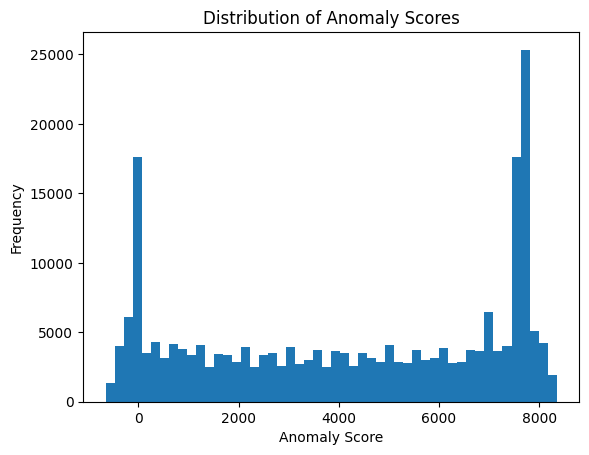

In [26]:
import matplotlib.pyplot as plt

plt.hist(data_with_scores['Anomaly Score'], bins=50)
plt.title('Distribution of Anomaly Scores')
plt.xlabel('Anomaly Score')
plt.ylabel('Frequency')
plt.show()




In [19]:
# find threshold of anomaly scores
threshold = np.percentile(anomaly_scores, 1)
threshold


-417.43508750429476

In [27]:
# use threshold to identifind the anomaly behavior
data_with_scores['Is_Anomaly'] = anomaly_scores < threshold

data_with_scores


,Account No,Balance,Amount,Third Party Name,Hour,DayOfWeek,Day,Is_Salary,Anomaly Score,Is_Anomaly
0,678330503.0,2971.000000,1584.00,Westport Care Home,0,6,1,False,21.761594,False
1,472213568.0,3792.000000,1950.00,Barbiee Boutique,0,6,1,False,18.317623,False
2,624500124.0,3226.000000,1825.00,Fat Face,0,6,1,False,29.935934,False
3,203466392.0,4607.660000,2841.66,Lavender Primary,0,6,1,False,7.685006,False
4,768271776.0,3620.000000,1950.00,A Cut Above,0,6,1,False,19.016573,False
...,...,...,...,...,...,...,...,...,...,...
223292,581655972.0,45935.206861,-41.06,Tesco,20,2,6,False,831.089592,False
223293,786141370.0,-244.837500,-62.35,Sainsbury Local,20,2,6,False,939.216655,False
223294,824916823.0,9709.172159,-32.94,Deliveroo,21,2,6,False,892.197236,False
223295,366550080.0,26834.165794,-19.25,Amazon,21,2,6,False,846.444095,False


In [23]:
neg[neg['Account No']==472213568.0]

,Account No,Balance,Amount,Third Party Name,Hour,DayOfWeek,Day,Is_Salary,Anomaly Score
801,472213568.0,2404.010000,-7.99,Disney,0,6,1,False,-1.807850
802,472213568.0,2388.020000,-15.99,Netflix,0,6,1,False,-1.238013
803,472213568.0,2382.030000,-5.99,Mojang Studios,0,6,1,False,-1.553827
804,472213568.0,2375.030000,-7.00,Xbox,0,6,1,False,-1.502786
805,472213568.0,2275.030000,-100.00,Grand Union BJJ,0,6,1,False,-2.959278
4513,472213568.0,2240.070000,-34.96,The Works,9,6,1,False,-226.136721
21290,472213568.0,3266.314181,1950.00,Barbiee Boutique,0,2,1,False,-32.062270
21768,472213568.0,1886.314181,-600.00,LBG,0,2,1,False,-39.027327
26619,472213568.0,1740.777190,-8.57,Lloyds Pharmacy,18,3,2,False,-202.805268
38662,472213568.0,2891.848897,1950.00,Barbiee Boutique,0,2,1,False,-31.084538


# it is big manitude minus if people get salary every month

In [28]:
data_with_scores

,Account No,Balance,Amount,Third Party Name,Hour,DayOfWeek,Day,Is_Salary,Anomaly Score,Is_Anomaly
0,678330503.0,2971.000000,1584.00,Westport Care Home,0,6,1,False,21.761594,False
1,472213568.0,3792.000000,1950.00,Barbiee Boutique,0,6,1,False,18.317623,False
2,624500124.0,3226.000000,1825.00,Fat Face,0,6,1,False,29.935934,False
3,203466392.0,4607.660000,2841.66,Lavender Primary,0,6,1,False,7.685006,False
4,768271776.0,3620.000000,1950.00,A Cut Above,0,6,1,False,19.016573,False
...,...,...,...,...,...,...,...,...,...,...
223292,581655972.0,45935.206861,-41.06,Tesco,20,2,6,False,831.089592,False
223293,786141370.0,-244.837500,-62.35,Sainsbury Local,20,2,6,False,939.216655,False
223294,824916823.0,9709.172159,-32.94,Deliveroo,21,2,6,False,892.197236,False
223295,366550080.0,26834.165794,-19.25,Amazon,21,2,6,False,846.444095,False


In [29]:
# show stats of 'Third Party Name'
transaction_stats = data_with_scores.groupby('Account No').agg({
    'Amount': ['mean', 'std', 'count', 'sum'],
    'Anomaly Score': ['mean', 'min', 'max']
}).reset_index()

transaction_stats


Account No      Amount                             Anomaly Score  \
                        mean         std count       sum          mean   
0    101531259.0   -6.138618  542.288502   123   -755.05   4512.404598   
1    104832000.0   20.163200  537.743358   150   3024.48   4075.056464   
2    105375973.0  -68.953973   63.153634   146 -10067.28   4528.587070   
3    106601471.0   54.059067  403.230116   193  10433.40   5038.661505   
4    108481285.0   16.293824  284.259313   353   5751.72   4314.366426   
..           ...         ...         ...   ...       ...           ...   
971  995615876.0    7.764837  461.347948   184   1428.73   4506.207385   
972  996042490.0  101.958465  806.786200   241  24571.99   4217.971592   
973  998390769.0  -11.995724  546.998582   152  -1823.35   4021.040841   
974  998405607.0  -61.069589   55.475049   146  -8916.16   5694.567407   
975  999752672.0   26.213981  527.619620   314   8231.19   3724.289907   

                              
            min          max  
0   -403.834412  8323.670202  
1   -460.249374  7926.475114  
2   -511.941524  8124.771354  
3   -539.605985  8312.980814  
4   -572.973638  8312.174776  
..          ...          ...  
971 -588.394650  8322.246655  
972 -460.271988  8184.532858  
973 -308.523172  7863.812091  
974 -324.578148  8138.433421  
975 -550.481484  8265.123207  

[976 rows x 8 columns]

In [30]:
# identify the rik of 'Anomaly Score'
transaction_stats['Risk Score'] = -transaction_stats['Anomaly Score', 'mean']

risk_threshold = transaction_stats['Risk Score'].quantile(0.95)

transaction_stats['Is_High_Risk'] = transaction_stats['Risk Score'] > risk_threshold

high_risk_accounts = transaction_stats[transaction_stats['Is_High_Risk']]
high_risk_accounts


Account No      Amount                                Anomaly Score  \
                        mean         std count          sum          mean   
29   130522384.0   16.112367  520.767670   169   2722.99000   3147.927959   
62   154246234.0   48.831111  575.772869   126   6152.72000   2508.442164   
67   160166876.0  -56.887241   42.727176   145  -8248.65000   3064.330203   
108  198051483.0   13.559769  445.095811   173   2345.84000   3168.823797   
122  214339619.0   -3.456175  394.363443   366  -1264.96000   3133.276133   
162  250895529.0  -96.858285  105.262073   274 -26539.17000   3150.053105   
170  255814263.0  106.341792  815.041889   173  18397.13000   3195.578254   
172  256045540.0   -4.381250  684.023431   112   -490.70000   3203.582459   
182  266777719.0 -103.096823  154.254148   299 -30825.95000   2666.153313   
194  282102606.0   77.399618  792.954413   131  10139.35000   1918.798326   
196  283027736.0  -55.266021   59.179571   191 -10555.81000   2984.614127   
197  284161641.0  -57.849545   57.599674   154  -8908.83000   2923.828239   
206  290751280.0    1.846502  431.808942   203    374.84000   3002.101194   
209  291580432.0   45.934386  726.379927   171   7854.78000   2893.584453   
218  299652176.0 -116.629600   83.308159   100 -11662.96000   2231.180127   
220  300095518.0  -59.725877   50.733309   114  -6808.75000   2552.030707   
243  331048953.0  -67.866432   56.671621   199 -13505.42000   3261.075097   
252  338022396.0   37.012484  639.117906   153   5662.91000   2008.731232   
259  344843570.0  -73.980866   70.234689   127  -9395.57000   2921.884752   
271  352899149.0   13.764048  411.746432   168   2312.36000   3279.990020   
326  409370545.0  -68.893239   55.211594   318 -21908.05000   3151.282028   
328  412823730.0  -63.961457   53.748250   151  -9658.18000   2921.599310   
348  427909748.0   85.086149  440.252237   161  13698.87000   3293.777573   
359  442070890.0   80.401545  931.897226   123   9889.39000   3279.990490   
360  442079728.0  -73.386538   74.950782   130  -9540.25000   2109.094467   
364  446720287.0  -84.476205   57.108372   166 -14023.05000   2962.046247   
375  456221621.0   -1.622458  410.522555   240   -389.39000   3256.526995   
500  567499591.0  110.613556  955.093168    45   4977.61000   2371.674302   
522  587202562.0   33.103649  728.439450   211   6984.87000   3016.175950   
586  642924505.0   31.989946  411.094676   217   6941.81820   3071.431416   
629  675398089.0  121.542529  453.455919    87  10574.20000   3099.412836   
637  680773155.0   -2.332801  389.149301   282   -657.85000   3195.005579   
652  691789577.0   91.154533  893.685330    75   6836.59000   2960.351831   
674  709151315.0  -68.727741   58.112308   185 -12714.63200   3085.889435   
679  711140907.0  -39.558205   38.525600   117  -4628.31000   3112.610146   
683  713910252.0   33.499508  738.873645   244   8173.88000   3093.202379   
687  719742742.0  -72.676462   64.319734   130  -9447.94000   2596.167993   
702  737547541.0  -17.258275  388.514677   240  -4141.98600   2564.799786   
710  744398361.0 -104.825939  149.712900   165 -17296.28000   3106.486601   
721  758885184.0   88.766071  694.940355   140  12427.25000   2827.900286   
755  786141370.0   -5.771477  523.112298   237  -1367.84000   3173.327216   
822  855129444.0   29.942544  599.122087   114   3413.45000   2744.455270   
858  889916166.0   46.840000  523.775400   134   6276.56000   2233.211526   
892  915666111.0   21.992703  835.696391    74   1627.46000   2187.522583   
910  936813994.0  -81.884388   45.744283   139 -11381.93000   2997.405857   
917  943829984.0   -4.235953  391.884722   257  -1088.63990   3281.109532   
934  965038148.0  -60.473158   61.774350   162  -9796.65153   3258.468922   
949  979135922.0 -132.917222  129.738037   216 -28710.12000   2741.454720   
951  980500334.0  -65.903093   49.280062   138  -9094.62680   3044.538664   

                               Risk Score Is_High_Risk  
            min      

In [32]:
high_risk_accounts.shape

(49, 10)